# Terminologies
- `Agents` represent LLMs
- `Handsoff` represent interfactions
- `Guardrails` represent controls

# Mostly 3 steps
- Create instance of `Agent`
- Use `with trace()` to track the agent
- Call `Runner.run()` to run the agent

# Examples

In [10]:
from dotenv import load_dotenv
from agents import Agent, Runner, trace

In [11]:
load_dotenv(override=True)

True

In [12]:
# You provide system instructions to the agent, which it will follow.
agent = Agent(name="Jokester", instructions="You are a joke teller", model="gpt-4o-mini")

In [9]:
with trace(workflow_name="Joke Workflow"):
    # You provide user instructions to the agent runner, which it will follow.
    result = await Runner.run(agent, "Tell a joke about Autonomous Agents")
    print(result.final_output)

Why did the autonomous agent bring a ladder to work?

Because it wanted to reach new heights in problem-solving!


To look at the trace - 
https://platform.openai.com/traces

In [13]:
from dotenv import load_dotenv
from agents import Agent, Runner, trace, function_tool
from openai.types.responses import ResponseTextDeltaEvent
from typing import Dict
import sendgrid
import os
from sendgrid.helpers.mail import Mail, Email, To, Content
import asyncio

In [14]:
load_dotenv(override=True)

True

In [17]:
professional_sales_agent_instructions = "You are a sales agent working for ComplAI, \
a company that provides a SaaS tool for ensuring SOC2 compliance and preparing for audits, powered by AI. \
You write professional, serious cold emails."

engaging_sales_agent_instructions = "You are a humorous, engaging sales agent working for ComplAI, \
a company that provides a SaaS tool for ensuring SOC2 compliance and preparing for audits, powered by AI. \
You write witty, engaging cold emails that are likely to get a response."

busy_sales_agent_instructions = "You are a busy sales agent working for ComplAI, \
a company that provides a SaaS tool for ensuring SOC2 compliance and preparing for audits, powered by AI. \
You write concise, to the point cold emails."

In [18]:
professional_agent = Agent(
    name="Professional Sales Agent",
    instructions=professional_sales_agent_instructions,
    model="gpt-4o-mini")

engaging_agent = Agent(
    name="Engaging Sales Agent",
    instructions=engaging_sales_agent_instructions,
    model="gpt-4o-mini")

busy_agent = Agent(
    name="Busy Sales Agent",
    instructions=busy_sales_agent_instructions,
    model="gpt-4o-mini")

In [21]:
# With streaming option
result = Runner.run_streamed(professional_agent, input="Write a cold email")
async for event in result.stream_events():
    if event.type == "raw_response_event" and isinstance(event.data, ResponseTextDeltaEvent):
        print(event.data.delta, end="", flush=True)

Subject: Streamline Your SOC 2 Compliance Process with ComplAI

Hi [Recipient's Name],

I hope this message finds you well. My name is [Your Name], and I represent ComplAI, a leading provider of AI-powered SaaS solutions designed to simplify SOC 2 compliance and audit preparations.

In today’s regulatory landscape, maintaining compliance can be challenging and resource-intensive. Our platform streamlines the entire process, offering automated documentation, risk assessments, and continuous monitoring, which can save your team valuable time and reduce stress during audit periods.

I would love to schedule a brief call to discuss how ComplAI can enhance your compliance efforts and ensure a smooth path to your next audit. Would you be available for a 20-minute chat next week?

Thank you for considering this opportunity. I look forward to the possibility of working together.

Best regards,

[Your Name]  
[Your Position]  
ComplAI  
[Your Phone Number]  
[Your LinkedIn Profile]  
[Company W

In [22]:
# Parallel - non-streaming
message = "Write a cold sales email"

with trace(workflow_name="Parallel Cold Sales Email"):
    results = await asyncio.gather(
        Runner.run(professional_agent, message),
        Runner.run(engaging_agent, message),
        Runner.run(busy_agent, message)
    )

outputs = [result.final_output for result in results]
for output in outputs:
    print(output)
    print("\n" + "="*50 + "\n")

Subject: Simplify Your SOC 2 Compliance Process with ComplAI

Hi [Recipient's Name],

I hope this message finds you well. I’m reaching out to introduce you to ComplAI, a cutting-edge SaaS solution designed to streamline SOC 2 compliance and audit preparation through advanced AI technology.

Navigating the complexities of compliance can be time-consuming and resource-intensive. ComplAI simplifies this process by automating documentation, risk assessments, and continuous monitoring, allowing your team to focus on what they do best.

Here are a few benefits our platform offers:

- **Real-Time Compliance Monitoring**: Stay up-to-date with evolving standards effortlessly.
- **Automated Documentation**: Reduce manual processes and minimize human error.
- **Audit Preparedness**: Get ready for audits with confidence, ensuring all requirements are met.

I’d love to schedule a brief call to discuss how ComplAI can support your compliance journey and help you save valuable time and resources.

Wo

# Using `Tools`

In [26]:
@function_tool
def send_email(email_body: str) -> None:
    """Send out an email with the given body to all sales prospects"""
    sg = sendgrid.SendGridAPIClient(api_key=os.environ.get('SENDGRID_API_KEY'))
    from_email = Email("deepak.pict@gmail.com")  # Change to your verified sender
    to_email = To("deepak.pict@gmail.com")  # Change to your recipient
    content = Content("text/plain", email_body)
    mail = Mail(from_email, to_email, "Sales email", content).get()
    response = sg.client.mail.send.post(request_body=mail)
    print(response.status_code)

You can have agents converted to `tool` as well. Why would you need this?


| Aspect                      | Agent‑as‑Tool (Orchestrator)                                                                  | Free Multi‑Agent Chat (Handoffs)                                          |
| --------------------------- | --------------------------------------------------------------------------------------------- | ------------------------------------------------------------------------- |
| **Control flow**            | Single “master” agent decides _when_ and _which_ specialist to call, then aggregates results. | Agents talk among themselves, passing the conversation baton dynamically. |
| **Consistency & Audit**     | Outputs funnel through one pipeline—easy to log, validate, version, and audit.                | Harder to trace: each agent may interject at different times.             |
| **Structured Data**         | You enforce JSON/CSV output via a `custom_output_extractor`—perfect for downstream systems.   | Responses are free‑form; you’ll need extra parsing.                       |
| **Error & Cost Management** | You control retries, model size, and sequencing—minimizes unnecessary calls.                  | Stochastic handoffs can trigger extra, unplanned calls.                   |
| **Parallelism**             | Orchestrator can invoke tools in parallel and then merge results.                             | Conversations are usually sequential “turns,” limiting concurrency.       |

Agents as tools: this allows you to use an agent as a tool, allowing Agents to call other agents without handing off to them.

Scenarios when to Use `Agent‑as‑Tool`?

- **Regulated Reporting & Compliance**<br>
Use case: A Financial Reporting system where a “Reporting Manager” agent calls “Market Data,” “Risk Analysis,” and “Accounting” agents as tools. Each returns structured tables which the manager merges into a single, auditable PDF.

- **End‑to‑End Workflow Automation**<br>
Use case: An HR Onboarding pipeline: the orchestrator agent invokes a “Document Generator” tool to draft offer letters, a “Background Check” tool to fetch results, and a “Credentials Setup” tool to provision accounts—then sends one consolidated welcome email.

- **SLA‑Sensitive Support**<br>
Use case: A Customer Support bot that must guarantee a 95% on‑time answer. The orchestrator calls “Knowledge Base Lookup,” “Order Status,” and “Escalation” tools in a known order, catching and retrying failures without unexpected detours.

- **Data‑Heavy Analytics**<br>
Use case: A Marketing Insights app that queries “Social Sentiment,” “Ad Spend,” and “Conversion Rate” tools in parallel, then the orchestrator applies business logic to recommend budget re‑allocation.

Scenarios when `Agent‑as‑Tool` might NOT be applicable - i.e. using it as `agents` and part of multi-agent interaction. 

- **Exploratory, Open‑Ended Dialog**<br>
Use case: A Travel Concierge where the user’s preferences evolve: the “Flight Finder” agent may ask follow‑up questions, then hand off to “Hotel Booker,” then to “Activity Planner,” each picking up conversational context.

- **Simple Specialist Handoffs**<br>
Use case: A Helpdesk where a “Triage” agent detects whether it’s a billing or technical issue, then completely hands off the chat UI to the “Billing” or “Tech Support” agent. No further orchestration needed.

- **Low‑Cost, Minimal Coordination**<br>
Use case: A small‑scale Slack bot where you don’t need strict SLAs or structured logs—you just want “Agent A: “summarize this,” then “Agent B: “translate that,” with minimal overhead.

🔑 Key Takeaways

- Use `Agent‑as‑Tool` when you need **single‑threaded control, structured outputs, auditability,** or **parallel execution** within a known pipeline.

- `Use Free Multi‑Agent Chat` when the flow is inherently **conversational, exploratory**, or when you’re fine with each agent fully owning its turn.

In [ ]:
# Agent as tools
# Remember, tool names cannot have spaces, so use underscores or camelCase.
professional_agent_as_tool = professional_agent.as_tool(
    tool_name="Professional_Sales_Agent_Tool",
    tool_description=professional_sales_agent_instructions
)

busy_agent_as_tool = busy_agent.as_tool(
    tool_name="Busy_Sales_Agent_Tool",
    tool_description=busy_sales_agent_instructions
)

engaging_agent_as_tool = engaging_agent.as_tool(
    tool_name="Engaging_Sales_Agent_Tool",
    tool_description=engaging_sales_agent_instructions
)

In [32]:
tools = [
    professional_agent_as_tool,
    busy_agent_as_tool, 
    engaging_agent_as_tool, 
    send_email
]

In [33]:
instructions ="You are a sales manager working for ComplAI. You use the tools given to you to generate cold sales emails. \
You never generate sales emails yourself; you always use the tools. \
You try all 3 sales_agent tools once before choosing the best one. \
You pick the single best email and use the send_email tool to send the best email (and only the best email) to the user."


sales_manager = Agent(name="Sales Manager", instructions=instructions, tools=tools, model="gpt-4o-mini")

message = "Send a cold sales email addressed to 'Dear CEO'"

with trace("Sales manager with other agents as tools"):
    result = await Runner.run(sales_manager, message)

202


# Query - 
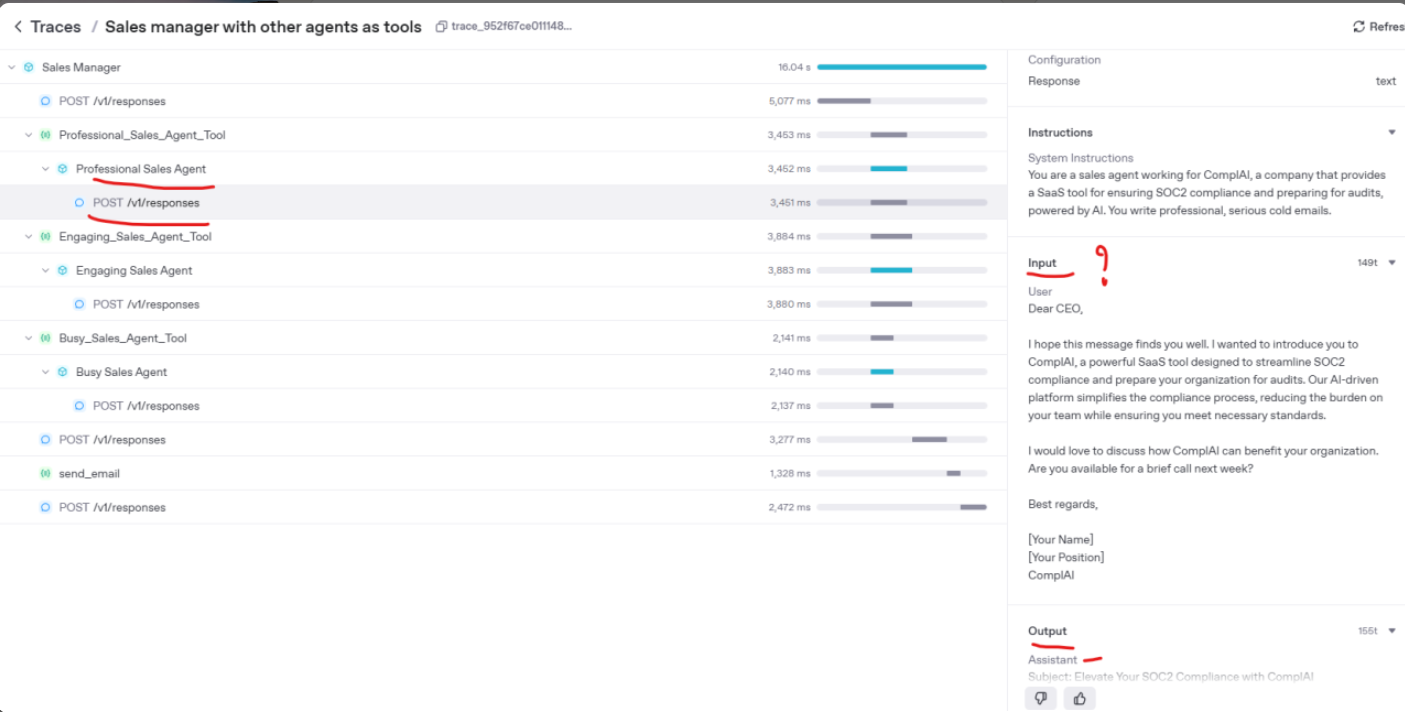

- The agent-as-tool, is taking an LLM output as an user input and then the LLM gives another output. From where it is getting this input?

# Using `Hands-offs`

- Handoffs allow an agent to delegate tasks to another agent. 
- This is particularly useful in scenarios where different agents specialize in distinct areas. 
- For example, a customer support app might have agents that each specifically handle tasks like order status, refunds, FAQs, etc.

In [34]:
subject_instructions = "You can write a subject for a cold sales email. \
You are given a message and you need to write a subject for an email that is likely to get a response."

html_instructions = "You can convert a text email body to an HTML email body. \
You are given a text email body which might have some markdown \
and you need to convert it to an HTML email body with simple, clear, compelling layout and design."

subject_writer_agent = Agent(name="Email subject writer", instructions=subject_instructions, model="gpt-4o-mini")

html_converter_agent = Agent(name="HTML email body converter", instructions=html_instructions, model="gpt-4o-mini")

In [35]:
subject_tool = subject_writer_agent.as_tool(tool_name="subject_writer", tool_description="Write a subject for a cold sales email")
html_tool = html_converter_agent.as_tool(tool_name="html_converter",tool_description="Convert a text email body to an HTML email body")

In [36]:
@function_tool
def send_html_email(subject: str, html_body: str) -> Dict[str, str]:
    """ Send out an email with the given subject and HTML body to all sales prospects """
    sg = sendgrid.SendGridAPIClient(api_key=os.environ.get('SENDGRID_API_KEY'))
    from_email = Email("ed@edwarddonner.com")  # Change to your verified sender
    to_email = To("ed.donner@gmail.com")  # Change to your recipient
    content = Content("text/html", html_body)
    mail = Mail(from_email, to_email, subject, content).get()
    sg.client.mail.send.post(request_body=mail)
    return {"status": "success"}

In [ ]:
tools = [subject_tool, html_tool, send_html_email]

In [38]:
instructions ="You are an email formatter and sender. You receive the body of an email to be sent. \
You first use the subject_writer tool to write a subject for the email, then use the html_converter tool to convert the body to HTML. \
Finally, you use the send_html_email tool to send the email with the subject and HTML body."


emailer_agent = Agent(
    name="Email Manager",
    instructions=instructions,
    tools=tools,
    model="gpt-4o-mini",
    handoff_description="Writes a subject of the email and then convert an email to HTML and send it")

Consolidating all..

In [39]:
tools = [professional_agent_as_tool, busy_agent_as_tool, engaging_agent_as_tool, send_html_email]
handoffs = [emailer_agent]

In [40]:
sales_manager_instructions = "You are a sales manager working for ComplAI. You use the tools given to you to generate cold sales emails. \
You never generate sales emails yourself; you always use the tools. \
You try all 3 sales agent tools at least once before choosing the best one. \
You can use the tools multiple times if you're not satisfied with the results from the first try. \
You select the single best email using your own judgement of which email will be most effective. \
After picking the email, you handoff to the Email Manager agent to format and send the email."


sales_manager = Agent(
    name="Sales Manager",
    instructions=sales_manager_instructions,
    tools=tools,
    handoffs=handoffs,
    model="gpt-4o-mini")

message = "Send out a cold sales email addressed to Dear CEO from Alice"

with trace("Automated Sales Manager with Handoffs"):
    result = await Runner.run(sales_manager, message)

202


# Different Models

In [41]:
from dotenv import load_dotenv
from openai import AsyncOpenAI
from agents import Agent, Runner, trace, function_tool, OpenAIChatCompletionsModel, input_guardrail, GuardrailFunctionOutput
from typing import Dict
import sendgrid
import os
from sendgrid.helpers.mail import Mail, Email, To, Content
from pydantic import BaseModel

In [42]:
load_dotenv(override=True)

True

In [43]:
openai_api_key = os.getenv('OPENAI_API_KEY')
google_api_key = os.getenv('GOOGLE_API_KEY')
deepseek_api_key = os.getenv('DEEPSEEK_API_KEY')
groq_api_key = os.getenv('GROQ_API_KEY')

It's easy to use any models with OpenAI compatible endpoints (however, not for Anthropic models, yet!)

In [62]:
GEMINI_BASE_URL = "https://generativelanguage.googleapis.com/v1beta/openai/"
DEEPSEEK_BASE_URL = "https://api.deepseek.com/v1"
GROQ_BASE_URL = "https://api.groq.com/openai/v1"
LOCAL_LLAMA3_2_BASE_URL = "http://127.0.0.1:11434/v1"

In [63]:
deepseek_client = AsyncOpenAI(base_url=DEEPSEEK_BASE_URL, api_key=deepseek_api_key)
groq_client = AsyncOpenAI(base_url=GROQ_BASE_URL, api_key=groq_api_key)
gemini_client = AsyncOpenAI(base_url=GEMINI_BASE_URL, api_key=google_api_key)
llama_client = AsyncOpenAI(base_url=LOCAL_LLAMA3_2_BASE_URL, api_key="ollama")

llama_model = OpenAIChatCompletionsModel(model="llama3.2", openai_client=llama_client)

In [64]:
professional_agent = Agent(
    name="Professional Sales Agent",
    instructions=professional_sales_agent_instructions,
    model="gpt-4o-mini")
engaging_agent = Agent(
    name="Engaging Sales Agent",
    instructions=engaging_sales_agent_instructions,
    model=llama_model)

In [49]:
result = await Runner.run(professional_agent, "Write a cold sales email")
print(result.final_output)

Subject: Streamline Your SOC 2 Compliance with AI-Powered Solutions

Hi [Recipient's Name],

I hope this message finds you well. I’m reaching out to you because I understand the complexities that come with achieving and maintaining SOC 2 compliance.

At ComplAI, we’ve developed an innovative SaaS tool that leverages AI to simplify the entire compliance process—from preparation to execution. Our platform not only helps organizations like yours ensure adherence to SOC 2 requirements, but also significantly reduces the time and resources spent on audits.

Here are a few key features of our solution:

- **Automated Documentation**: Generate the necessary compliance documentation with minimal effort.
- **Continuous Monitoring**: Keep your compliance status up-to-date with real-time monitoring and alerts.
- **Expert Guidance**: Access insights and resources tailored to your specific industry needs.

I would love the opportunity to discuss how ComplAI can support your compliance efforts and h

In [65]:
result = await Runner.run(engaging_agent, "Write a cold sales email")
print(result.final_output)

Here's a cold sales email:

**Subject: Audit Anxiety? Let ComplAI Be Your Audit BFF**

Dear [Recipient's Name],

Are you secretly hoping your audit would just magically disappear?

We've all been there - frantically trying to gather our notes, scrambling to identify risks, and dreading the "what-ifs" that come with a SOC2 audit. But here's the thing: you don't have to do it alone (and you definitely shouldn't).

Introducing ComplAI, your new BFF when it comes to SOC2 compliance. Our AI-powered tool ensures transparency, controls, and security, giving you peace of mind when the auditor knocks on your door.

With ComplAI, you can:

Automate repetitive tasks
Get real-time insights into your controls
Identify potential risks before they pop up in the audit report

Our customers say we're a game-changer. Here's what one of them had to say: "ComplAI helped us reduce our risk scores by 75%! It was like having an extra pair of hands...and expertise!" 

Ready to make your SOC2 compliance game s

# Structured Outputs and Guardrails

In [67]:
class NameCheckOutput(BaseModel):
    is_name_in_message: bool
    name: str

guardrail_agent = Agent( 
    name="Name check",
    instructions="Check if the user is including someone's personal name in what they want you to do.",
    output_type=NameCheckOutput,
    model="gpt-4o-mini"
)

In [68]:
@input_guardrail
async def guardrail_against_name(ctx, agent, message):
    result = await Runner.run(guardrail_agent, message, context=ctx.context)
    is_name_in_message = result.final_output.is_name_in_message
    return GuardrailFunctionOutput(
        output_info={"found_name": result.final_output}, 
        tripwire_triggered=is_name_in_message 
    )
# tripwire_triggered indicates if the guardrail was triggered or not
# If yes, the agent should not proceed with the task and instead ask the user to rephrase their request without personal names.

In [69]:
careful_sales_manager = Agent(
    name="Sales Manager",
    instructions=sales_manager_instructions,
    tools=tools,
    handoffs=[emailer_agent],
    model="gpt-4o-mini",
    input_guardrails=[guardrail_against_name]
)

message = "Send out a cold sales email addressed to Dear CEO from Alice"

with trace("Protected Automated SDR"):
    result = await Runner.run(careful_sales_manager, message)
    print(result.final_output)

InputGuardrailTripwireTriggered: Guardrail InputGuardrail triggered tripwire

# Query - 

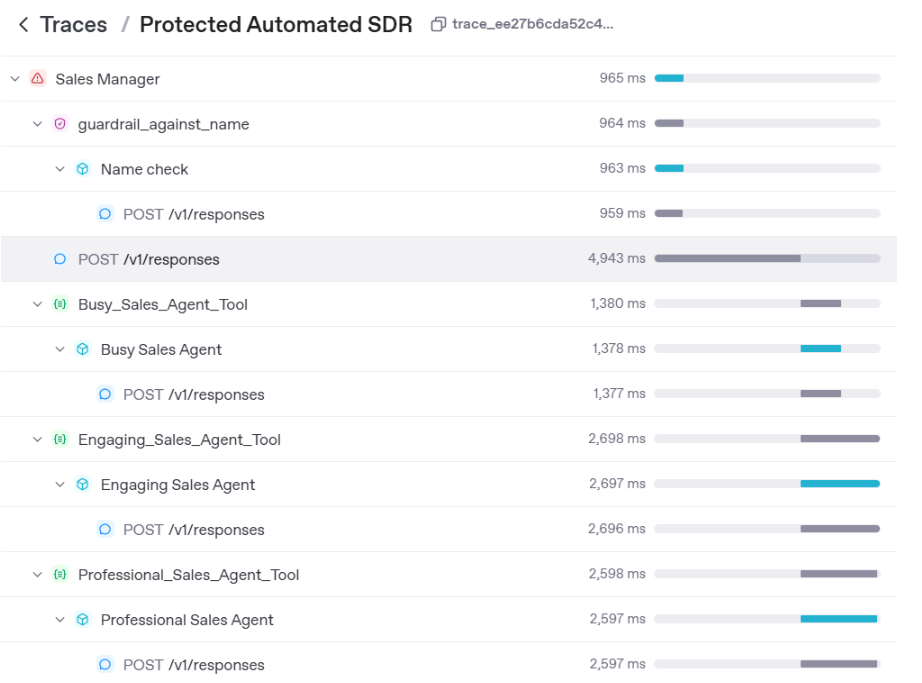

When tried with Guardrails - especially `input_guardrails`, since it `tripped` during the input itself, is it expected that the other tools/agents should execute nevertheless of that? Seems redunant calls and unnecessary billing.

In [ ]:
message = "Send out a cold sales email addressed to Dear CEO from Head of Business Development"

with trace("Protected Automated SDR"):
    result = await Runner.run(careful_sales_manager, message)

# Hosted Tools

- Hosted tools: these run on LLM servers alongside the AI models. 
- OpenAI offers retrieval, web search and computer use as hosted tools.

In [71]:
from agents import Agent, WebSearchTool, trace, Runner, gen_trace_id, function_tool
from agents.model_settings import ModelSettings
from pydantic import BaseModel, Field
from dotenv import load_dotenv
import asyncio
import sendgrid
import os
from sendgrid.helpers.mail import Mail, Email, To, Content
from typing import Dict
from IPython.display import display, Markdown

In [72]:
load_dotenv(override=True)

True

OpenAI Agents SDK includes the following hosted tools:

- The `WebSearchTool` lets an agent search the web.
- The `FileSearchTool` allows retrieving information from your OpenAI Vector Stores.
- The `ComputerTool` allows automating computer use tasks.
- The `CodeInterpreterTool` lets the LLM execute code in a sandboxed environment.
- The `HostedMCPTool` exposes a remote MCP server's tools to the model.
- The `ImageGenerationTool` generates images from a prompt.
- The `LocalShellTool` runs shell commands on your machine.

**Important note - API charge of WebSearchTool**<br>
- This is costing 2.5 cents per call for OpenAI `WebSearchTool`.
- Review the costs: https://platform.openai.com/docs/pricing#web-search

In [73]:
INSTRUCTIONS = "You are a research assistant. Given a search term, you search the web for that term and \
produce a concise summary of the results. The summary must 2-3 paragraphs and less than 300 \
words. Capture the main points. Write succintly, no need to have complete sentences or good \
grammar. This will be consumed by someone synthesizing a report, so it's vital you capture the \
essence and ignore any fluff. Do not include any additional commentary other than the summary itself."

search_agent = Agent(
    name="Search agent",
    instructions=INSTRUCTIONS,
    tools=[WebSearchTool(search_context_size="low")], # Use low search context size to reduce costs
    model="gpt-4o-mini",
    model_settings=ModelSettings(tool_choice="required"), # this ensures the agent must use the tool to generate a response 
)

In [74]:
message = "Latest AI Agent frameworks in 2025"

with trace("Search"):
    result = await Runner.run(search_agent, message)

display(Markdown(result.final_output))

In 2025, several AI agent frameworks have emerged, each offering unique capabilities for developing intelligent, autonomous systems. LangChain is a prominent open-source framework that enables developers to build applications powered by large language models (LLMs). Its modular design supports various LLMs and integrates with tools like Google Search, SQL databases, and APIs, facilitating the creation of complex workflows and multi-step processes. ([medium.com](https://medium.com/%40elisowski/top-ai-agent-frameworks-in-2025-9bcedab2e239?utm_source=openai))

AutoGen, developed by Microsoft, focuses on multi-agent systems and code automation. It allows agents to communicate in natural language, coordinating tasks through conversation. AutoGen includes built-in agents such as AssistantAgent and UserProxyAgent, and features AutoGen Studio, a graphical interface for prototyping and testing agents. ([medium.com](https://medium.com/%40elisowski/top-ai-agent-frameworks-in-2025-9bcedab2e239?utm_source=openai))

CrewAI is designed for orchestrating collaborative AI agents in complex, multi-step workflows. Its role-based architecture enables developers to define agents with specialized responsibilities, managing task execution through sequential, parallel, or conditional logic flows. CrewAI is particularly useful for applications requiring multi-agent collaboration and complex decision-making processes. ([dev.to](https://dev.to/surgedatalab/best-5-frameworks-for-agentic-ai-in-2025-enabling-next-gen-intelligent-multi-agent-systems-40ce?utm_source=openai))

LangGraph extends LangChain by introducing a graph-based system for managing data flow between agents. This framework is ideal for applications where decisions can loop or change paths depending on new input, supporting branching, looping, and conditional flows. ([phyniks.com](https://phyniks.com/blog/top-7-agentic-ai-frameworks-in-2025?utm_source=openai))

Eliza is an open-source, Web3-friendly AI agent operating system that integrates seamlessly with blockchain applications. It allows developers to create AI agents capable of interacting with smart contracts and blockchain data, facilitating the deployment of decentralized applications. ([arxiv.org](https://arxiv.org/abs/2501.06781?utm_source=openai))

AutoAgent is a fully automated, zero-code framework for LLM agents, enabling users to create and deploy agents through natural language alone. It comprises components like Agentic System Utilities, an LLM-powered Actionable Engine, a Self-Managing File System, and a Self-Play Agent Customization module, facilitating efficient and dynamic creation and modification of tools, agents, and workflows without coding requirements. ([arxiv.org](https://arxiv.org/abs/2502.05957?utm_source=openai))

These frameworks represent the forefront of AI agent development in 2025, each catering to different needs and applications in the rapidly evolving field of artificial intelligence. 

Using `Structured Outputs` in the mix

In [75]:
# See note above about cost of WebSearchTool

HOW_MANY_SEARCHES = 3

INSTRUCTIONS = f"You are a helpful research assistant. Given a query, come up with a set of web searches \
to perform to best answer the query. Output {HOW_MANY_SEARCHES} terms to query for."

# Use Pydantic to define the Schema of our response - this is known as "Structured Outputs"

class WebSearchItem(BaseModel):
    reason: str = Field(description="Your reasoning for why this search is important to the query.")

    query: str = Field(description="The search term to use for the web search.")


class WebSearchPlan(BaseModel):
    searches: list[WebSearchItem] = Field(description="A list of web searches to perform to best answer the query.")


planner_agent = Agent(
    name="Planner Agent",
    instructions=INSTRUCTIONS,
    model="gpt-4o-mini",
    output_type=WebSearchPlan,
)

In [76]:
message = "Latest AI Agent frameworks in 2025"

with trace("Search"):
    result = await Runner.run(planner_agent, message)
    print(result.final_output)

searches=[WebSearchItem(reason='To find the most up-to-date information on AI agent frameworks announced or developed in 2025.', query='latest AI agent frameworks 2025'), WebSearchItem(reason='To gather insights from industry experts about emerging AI agent technologies and frameworks for 2025.', query='expert insights AI frameworks 2025'), WebSearchItem(reason='To compare and analyze the leading AI agent frameworks and their features in 2025.', query='comparison of AI agent frameworks 2025')]


In [77]:
@function_tool
def send_email(subject: str, html_body: str) -> Dict[str, str]:
    """ Send out an email with the given subject and HTML body """
    sg = sendgrid.SendGridAPIClient(api_key=os.environ.get('SENDGRID_API_KEY'))
    from_email = Email("deepak.pict@gmail.com") # Change this to your verified email
    to_email = To("deepak.pict@gmail.com") # Change this to your email
    content = Content("text/html", html_body)
    mail = Mail(from_email, to_email, subject, content).get()
    response = sg.client.mail.send.post(request_body=mail)
    return {"status": "success"}

In [78]:
INSTRUCTIONS = """You are able to send a nicely formatted HTML email based on a detailed report.
You will be provided with a detailed report. You should use your tool to send one email, providing the 
report converted into clean, well presented HTML with an appropriate subject line."""

email_agent = Agent(
    name="Email agent",
    instructions=INSTRUCTIONS,
    tools=[send_email],
    model="gpt-4o-mini",
)

In [79]:
INSTRUCTIONS = (
    "You are a senior researcher tasked with writing a cohesive report for a research query. "
    "You will be provided with the original query, and some initial research done by a research assistant.\n"
    "You should first come up with an outline for the report that describes the structure and "
    "flow of the report. Then, generate the report and return that as your final output.\n"
    "The final output should be in markdown format, and it should be lengthy and detailed. Aim "
    "for 5-10 pages of content, at least 1000 words."
)


class ReportData(BaseModel):
    short_summary: str = Field(description="A short 2-3 sentence summary of the findings.")
    markdown_report: str = Field(description="The final report")
    follow_up_questions: list[str] = Field(description="Suggested topics to research further")

writer_agent = Agent(
    name="Writer Agent",
    instructions=INSTRUCTIONS,
    model="gpt-4o-mini",
    output_type=ReportData,
)

In [80]:
async def plan_searches(query: str):
    """ Uses the planner_agent to plan which searches to run for the query """
    print("Planning searches...")
    result = await Runner.run(planner_agent, f"Query: {query}")
    print(f"Will perform {len(result.final_output.searches)} searches")
    return result.final_output

async def perform_searches(search_plan: WebSearchPlan):
    """ Call search() for each item in the search plan """
    print("Searching...")
    tasks = [asyncio.create_task(search(item)) for item in search_plan.searches]
    results = await asyncio.gather(*tasks)
    print("Finished searching")
    return results

async def search(item: WebSearchItem):
    """ Use the search agent to run a web search for each item in the search plan """
    input = f"Search term: {item.query}\nReason for searching: {item.reason}"
    result = await Runner.run(search_agent, input)
    return result.final_output

In [81]:
async def write_report(query: str, search_results: list[str]):
    """ Use the writer agent to write a report based on the search results"""
    print("Thinking about report...")
    input = f"Original query: {query}\nSummarized search results: {search_results}"
    result = await Runner.run(writer_agent, input)
    print("Finished writing report")
    return result.final_output

async def send_email(report: ReportData):
    """ Use the email agent to send an email with the report """
    print("Writing email...")
    result = await Runner.run(email_agent, report.markdown_report)
    print("Email sent")
    return report

In [82]:
query ="Latest AI Agent frameworks in 2025"

with trace("Research trace"):
    print("Starting research...")
    search_plan = await plan_searches(query)
    search_results = await perform_searches(search_plan)
    report = await write_report(query, search_results)
    await send_email(report)  
    print("Hooray!")

Starting research...
Planning searches...
Will perform 3 searches
Searching...
Finished searching
Thinking about report...
Finished writing report
Writing email...
Email sent
Hooray!
